# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Python Installation**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Strategy Analytics

In this notebook, we will be further analyse the performance of the strategy created using the regression tree model.

### Import the data

The close price and the signals generated using the regression tree is stored in `predicted_signal_regression_tree.csv`.

### Trade details and strategy analytics

In [1]:
import pandas as pd
data = pd.read_csv('../data_modules/predicted_signal_regression_tree.csv', index_col=0)
data.index = pd.to_datetime(data.index)


In [3]:
def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    trades = pd.DataFrame()
    current_position = 0
    entry_time = ''

    for i in data.index:

        new_position = data.loc[i, signal_column]

        if new_position != current_position:    

            if entry_time != '':                   
                entry_price = data.loc[entry_time, close_column]
                exit_time = i
                exit_price = data.loc[exit_time, close_column]
                trade_details = pd.DataFrame([(current_position,entry_time, entry_price, exit_time,exit_price)])
                trades = trades.append(trade_details,ignore_index=True)  
                entry_time = ''            

            if new_position != 0:
                entry_time = i
            current_position = new_position


    trades.columns = ['Position','Entry Time','Entry Price','Exit Time','Exit Price']
    trades['PnL'] = (trades['Exit Price'] - trades['Entry Price']) * trades['Position']
    return trades

def get_analytics(trades):
    """Function to generate strategy analytics
    """

    analytics = pd.DataFrame(index=['Strategy'])
    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position==1])
    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position==-1])
    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + analytics.num_of_short
    
    # Gross Profit
    analytics['gross_profit'] = trades.loc[trades.PnL>0].PnL.sum()
    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL<0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[trades.PnL>0])
    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL<=0])
    # Win percentage
    analytics['win_percentage'] = 100*analytics.winners/analytics.total_trades
    # Loss percentage
    analytics['loss_percentage'] = 100*analytics.losers/analytics.total_trades
    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL>0].PnL.mean()
    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL<=0].PnL.mean()

    return analytics.T

In [4]:


trades = get_trades(data, 'Close', 'predicted_signal')
print('Trade Details')
trades.head()

Trade Details


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_88444/1411353334.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trades = trades.append(trade_details,ignore_index=True)


,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,1,2016-04-05,109.81,2016-04-07,108.54,-1.27
1,-1,2016-04-07,108.54,2016-04-12,110.44,-1.90
2,1,2016-04-12,110.44,2016-06-02,97.72,-12.72
3,-1,2016-06-02,97.72,2016-06-08,98.94,-1.22
4,1,2016-06-08,98.94,2016-06-15,97.14,-1.80


## Visualise the Entry and Exit

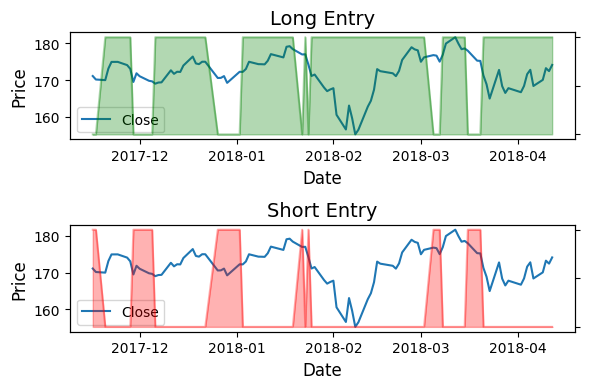

In [5]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Showing the last 100 points for illustration purpose
data_for_plot = data[-100:]
data_for_plot['long_entry'] = data_for_plot.predicted_signal == 1
data_for_plot['short_entry'] = data_for_plot.predicted_signal == -1

fig = plt.figure(figsize=(6, 4))

# Sub plot for the long position
ax = fig.add_subplot(211)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')

# Set the title and axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()

# Plot the time where the long position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(data_for_plot['long_entry'].index,
                 data_for_plot['long_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')


# Set the title and axis labels
ax.set_title('Short Entry', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()

# Plot the time where the short position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(data_for_plot['short_entry'].index,
                 data_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

1. In both graphs, the blue line indicates the close price of the underlying asset. 
2. In the first graph, you can see the green shaded region. This indicates the period where you are long on the underlying asset. 
3. The start of the green box will indicate the entry and the end of the green box will indicate the exit from the long position.
4. The second graph shows the same for the short position. The red shaded region is where we are short on the asset. And the entry and exit logic remain the same.

In [6]:
analytics = get_analytics(trades)
print('Strategy Analytics')
round(analytics,2)

Strategy Analytics


,Strategy
num_of_long,35.00
num_of_short,35.00
total_trades,70.00
gross_profit,123.32
gross_loss,-84.42
net_profit,38.90
winners,38.00
losers,32.00
win_percentage,54.29
loss_percentage,45.71


Start date,2016-04-06
End date,2018-04-12
Total months,24
,Backtest
Annual return,12.3%
Cumulative returns,26.4%
Annual volatility,20.3%
Sharpe ratio,0.67
Calmar ratio,0.58
Stability,0.83
Max drawdown,-21.4%


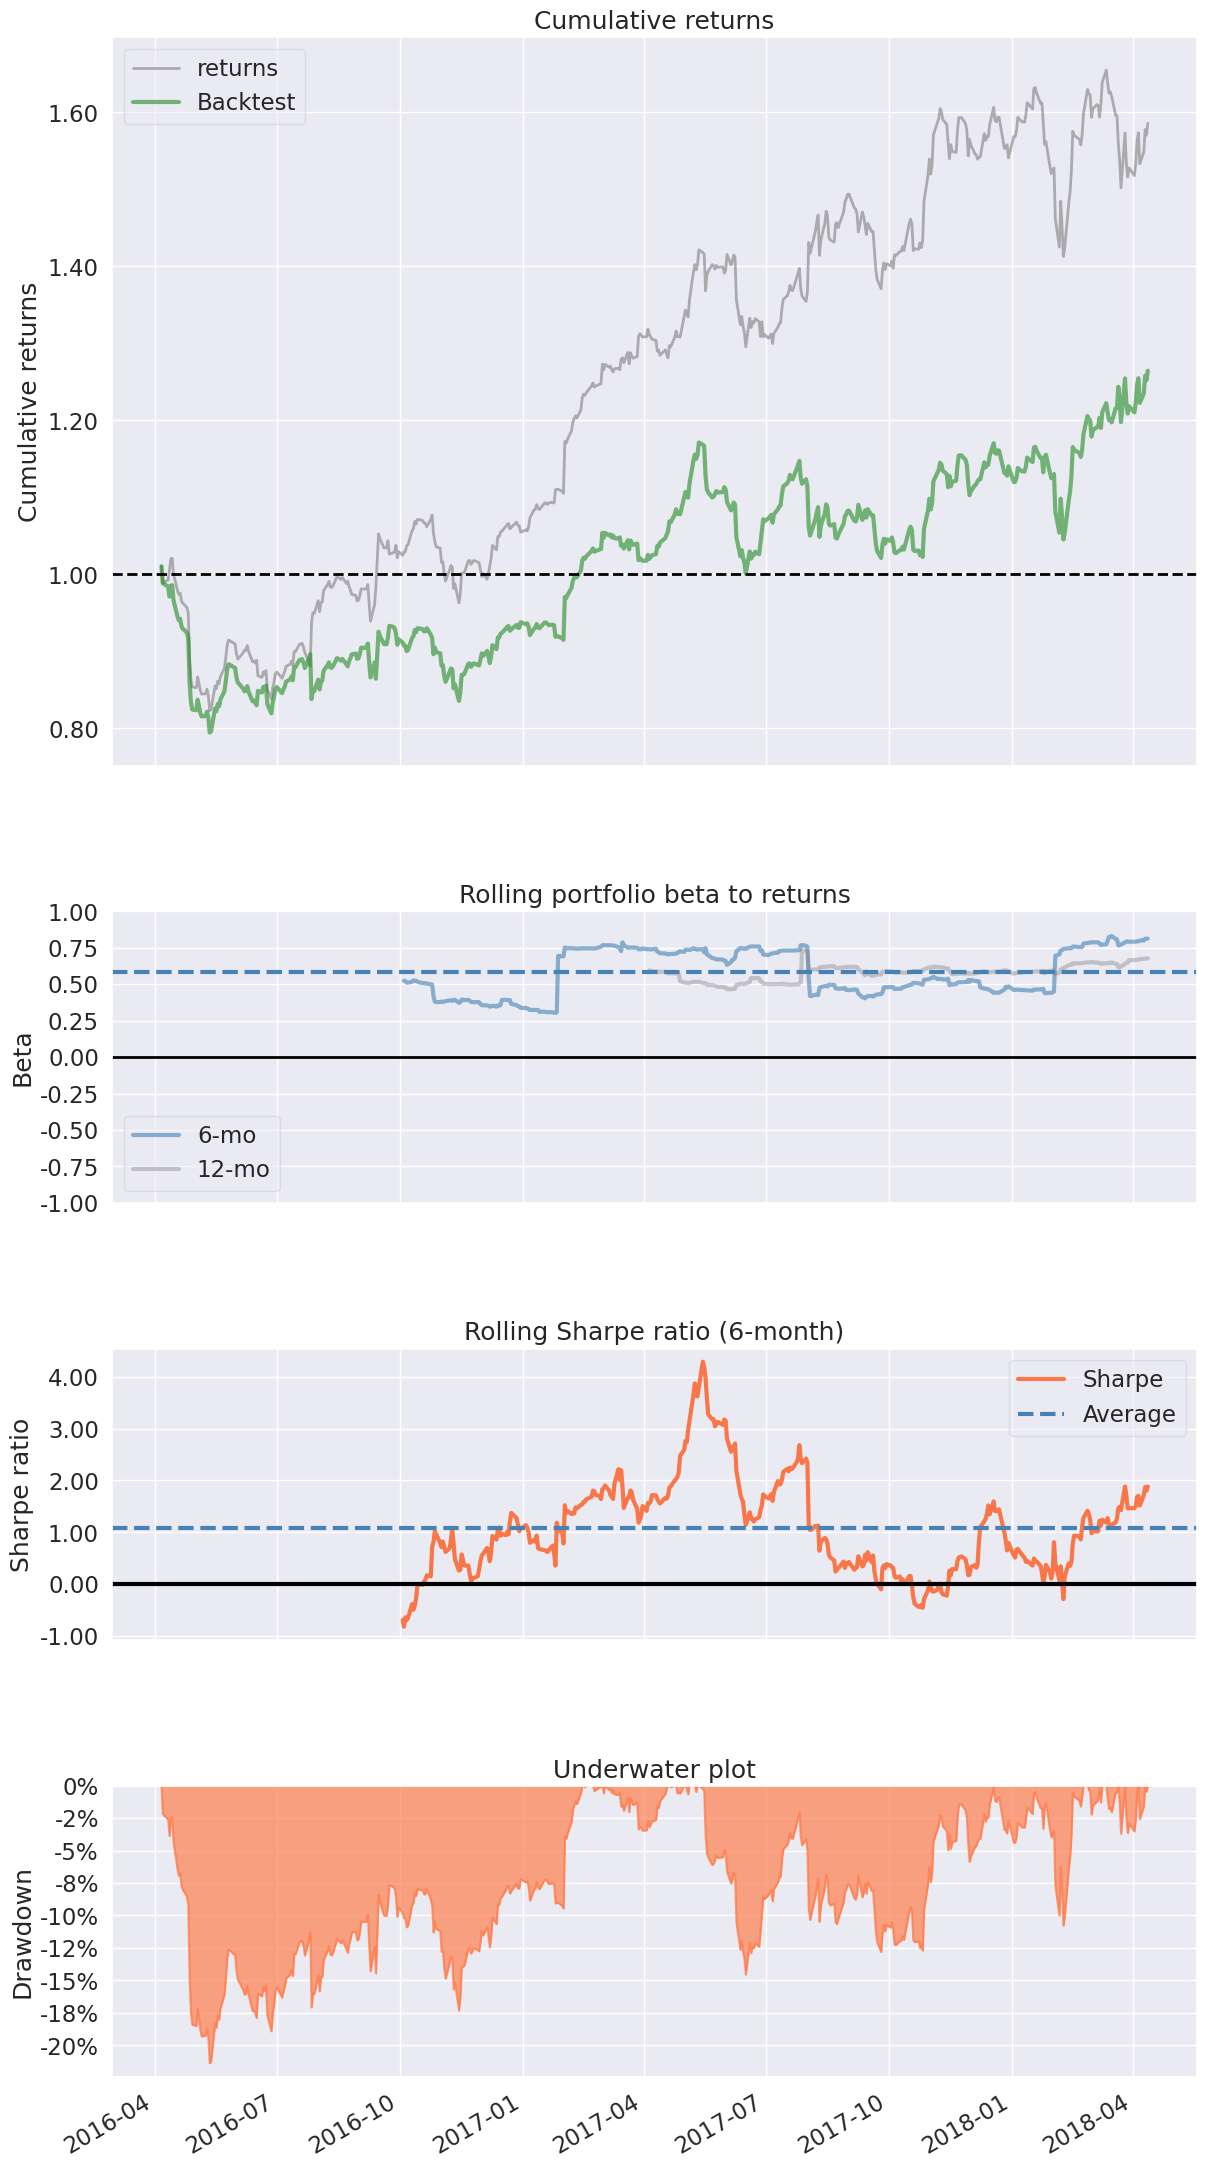

In [7]:
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")

data['returns'] = data.Close.pct_change()
data['strategy_returns'] = data['returns'] * data['predicted_signal'].shift(1)
data = data.dropna()
pf.create_simple_tear_sheet(data['strategy_returns'],benchmark_rets=data['returns']) 

 In the next section, we will explore some ensemble techniques for reducing overfitting so that we can, in fact, use all leaves for prediction.
<BR>